# TP2 - Detector de Máximo Enfoque





30 fotogramas por segundo, video de 5 segundos --> 150 frames

In [1]:
%matplotlib inline
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

In [2]:
def mostrar_imagen(imagen, titulo=''):
    plt.figure(figsize=(10, 6))
    plt.imshow(cv.cvtColor(imagen, cv.COLOR_BGR2RGB))
    plt.title(titulo)
    plt.axis('off')
    plt.show()

### 1. Implementación del algoritmo que calcula la métrica propuesta

Se implementa el algoritmo que calcula la métrica propuesta en el paper "Image Sharpness Measure for Blurred Images in Frequency Domain“ (Kanjar De and V. Masilamani (2013), Procedia Engineering 64 p149–158).

Tal como se explica en el paper, esta métrica está relacionada con la cantidad de componentes de alta frecuencia en la imagen. Cuanta mayor sea el número de componentes de alta frecuencia en la imagen, mejor será la calidad de la imagen (tendrá menor desenfoque o *blurring*).

El algoritmo consiste en los siguientes pasos:

**Algoritmo para Métrica de Calidad de Imagen *(Image Quality Measure)***
- Input: Imagen I de tamaño M×N.
- Output: Image Quality measure (FM), donde FM es la Frequency Domain Image Blur Measure (medida de desenfoque en el dominio de la frecuencia)
- Paso 1: Computar F, que es la Transformada de Fourier de la imagen I.
- Paso 2: Encontrar Fc, obtenida haciendo el shift del origen de F al centro.
- Paso 3: Calcular AF = abs (Fc), donde AF es el valor absoluto de la transformada de Fourier centrada de I.
- Paso 4: Calcular M = max (AF), donde M es el valor máximo de la frecuencia en F.
- Paso 5: Calcular TH = cantidad total de pixels de F donde el valor de pixel > umbral, siendo el umbral = M/1000.
- Paso 6: Calcular Image Quality measure (FM) como:
- *Image Quality Measure (FM) = Th / (M x N)*

In [3]:
def ImageQualityMeasure(image):
    """
    Calcula la medida de calidad de imagen según el algoritmo propuesto en el paper "Image
    Sharpness Measure for Blurred Images in Frequency Domain“.
    Args:
        image (numpy.ndarray): Imagen de entrada en formato BGR.
    Returns:
        FM (float): Valor de la medida de calidad de imagen (Frequency Domain Image Blur Measure).
    """
    # Paso 1: Computar F, que es la Transformada de Fourier de la imagen I.
    img_fft=np.fft.fft2(image)

    # Paso 2: Encontrar Fc, obtenida haciendo el shift del origen de F al centro.
    img_fft=np.fft.fftshift(img_fft)

    # Paso 3: Calcular AF = abs (Fc), donde AF es el valor absoluto de la transformada de Fourier centrada de I.
    AF = np.abs(img_fft)

    # Paso 4: Calcular M = max (AF), donde M es el valor máximo de la frecuencia en F.
    M = np.max(AF)

    # Paso 5: Calcular TH = cantidad total de pixels de F donde el valor de pixel > umbral, siendo el umbral = M/1000.
    thres = M / 1000
    TH = np.sum(AF > thres)
    
    # Paso 6: Calcular Image Quality measure (FM) como: FM = Th / (M x N)*
    M, N = image.shape[:2]
    FM = TH / (M * N)

    return FM

### 1.1 Medición sobre todo el frame

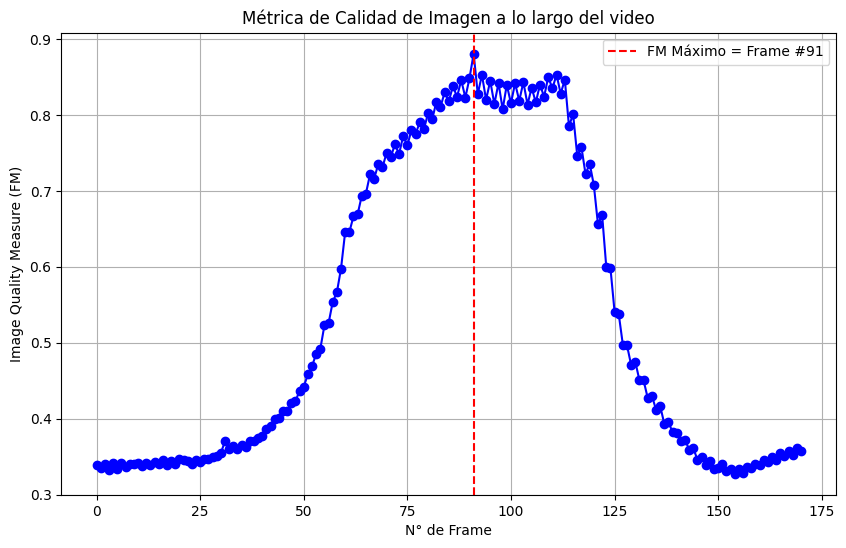

In [4]:
# Abre el video
video_path = 'videos/focus_video.mov'
captura_video = cv.VideoCapture(video_path)

if not captura_video.isOpened():
    print("Error al abrir el archivo de video")
else:
    num_frames = int(captura_video.get(cv.CAP_PROP_FRAME_COUNT))
    FM = []
    for i in range(num_frames):
        ret, frame = captura_video.read()
        if ret:
            FM.append(ImageQualityMeasure(frame))
        else:
            break

# Libera el objeto de captura de video
captura_video.release()
cv.destroyAllWindows()

# Calcula el frame con máximo valor de FM
max_FM = np.max(FM)
max_frame_index = np.argmax(FM)

# Muestra los resultados
plt.figure(figsize=(10, 6))
plt.plot(FM, marker='o', color='b')
plt.axvline(x=max_frame_index, color='r', linestyle='--', label=f'FM Máximo = Frame #{max_frame_index}')
plt.title('Métrica de Calidad de Imagen a lo largo del video')
plt.xlabel('N° de Frame')
plt.ylabel('Image Quality Measure (FM)')
plt.grid()
plt.legend()
plt.show()

Mostrar el frame con el máximo enfoque:

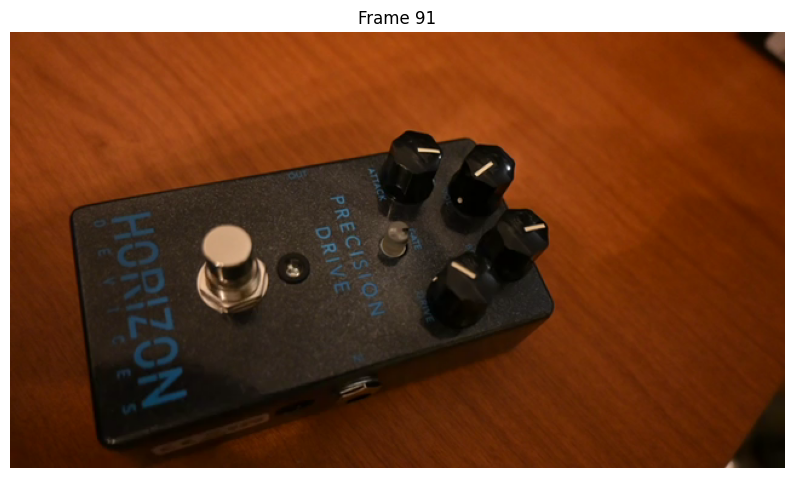

In [5]:
# Abre el video
video_path = 'videos/focus_video.mov'
captura_video = cv.VideoCapture(video_path)

# Define el número de frame a leer
n_frame = max_frame_index

# Verifica si el video se abrió correctamente
if not captura_video.isOpened():
    print("Error al abrir el archivo de video")
else:
    # Llevar el video al frame deseado y leerlo
    captura_video.set(cv.CAP_PROP_POS_FRAMES, n_frame)
    ret, frame = captura_video.read()
    if ret:
        mostrar_imagen(frame, titulo=f'Frame {n_frame}')

# Libera el objeto de captura de video
captura_video.release()
cv.destroyAllWindows()

### 1.2 Medición sobre una ROI ubicada en el centro del frame. 

Área de la ROI = 5 o 10% del área total del frame.

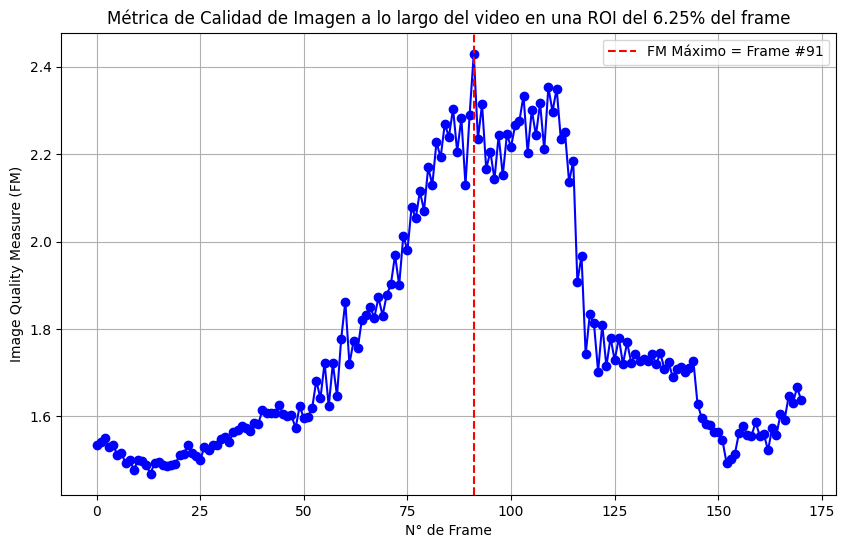

In [6]:
# Abre el video
video_path = 'videos/focus_video.mov'
captura_video = cv.VideoCapture(video_path)

if not captura_video.isOpened():
    print("Error al abrir el archivo de video")
else:
    # Obtener una ROI del video con un área del 5% del frame

    # Obtiene el tamaño del frame
    frame_width = int(captura_video.get(cv.CAP_PROP_FRAME_WIDTH))
    frame_height = int(captura_video.get(cv.CAP_PROP_FRAME_HEIGHT))
    
    # Define el tamaño de la ROI (5% del área total)
    roi_width = int(frame_width * 0.25)
    roi_height = int(frame_height * 0.25)
    
    # Calcula las coordenadas de la ROI centrada
    x_start = (frame_width - roi_width) // 2
    y_start = (frame_height - roi_height) // 2
    
    num_frames = int(captura_video.get(cv.CAP_PROP_FRAME_COUNT))
    FM = []
    for i in range(num_frames):
        ret, frame = captura_video.read()
        if ret:
            # Extraer la ROI del frame actual y calcular métrica
            roi_frame = frame[y_start:y_start + roi_height, x_start:x_start + roi_width]
            FM.append(ImageQualityMeasure(roi_frame))
        else:
            break

# Libera el objeto de captura de video
captura_video.release()
cv.destroyAllWindows()

# Calcula el frame con máximo valor de FM
max_FM = np.max(FM)
max_frame_index = np.argmax(FM)

# Área de la imagen con respecto al frame original
area=(roi_width*roi_height) / (frame_width*frame_height) * 100

# Muestra los resultados
plt.figure(figsize=(10, 6))
plt.plot(FM, marker='o', color='b')
plt.axvline(x=max_frame_index, color='r', linestyle='--', label=f'FM Máximo = Frame #{max_frame_index}')
plt.title(f'Métrica de Calidad de Imagen a lo largo del video en una ROI del {area:.2f}% del frame')
plt.xlabel('N° de Frame')
plt.ylabel('Image Quality Measure (FM)')
plt.grid()
plt.legend()
plt.show()

Mostrar el frame con el máximo enfoque en la ROI:

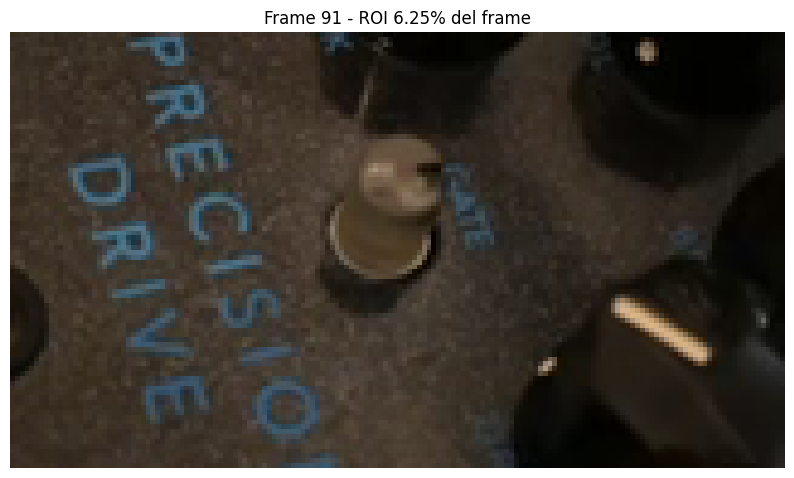

In [7]:
# Abre el video
video_path = 'videos/focus_video.mov'
captura_video = cv.VideoCapture(video_path)

# Define el número de frame a leer
n_frame = max_frame_index

# Verifica si el video se abrió correctamente
if not captura_video.isOpened():
    print("Error al abrir el archivo de video")
else:
    # Llevar el video al frame deseado y leerlo
    captura_video.set(cv.CAP_PROP_POS_FRAMES, n_frame)
    ret, frame = captura_video.read()
    roi_frame = frame[y_start:y_start + roi_height, x_start:x_start + roi_width]
    if ret:
        mostrar_imagen(roi_frame, titulo=f'Frame {n_frame} - ROI {area:.2f}% del frame')

# Libera el objeto de captura de video
captura_video.release()
cv.destroyAllWindows()

En ambos experimentos se obtiene el máximo enfoque en el mismo frame (Frame #91). A partir de estos resultados, se observa que analizando una ROI con un área del 6.25% del frame original es posible alcanzar el mismo resultado que analizando el frame completo. 

### 2. Cambiar métrica a uno de los algoritmos de "Analysis of focus measure operators in shapefrom focus"

Modificamos la métrica de medición de enfoque al algoritmo de Brenner, presente en el paper. Como este algoritmo se aplica en imágenes grayscale, convertimos la imagen previamente a ese formato:

In [8]:
def ImageQualityMeasureBrenner(image):
    """
    Calcula la medida de calidad de imagen utilizando el Brenner focus measure para imágenes en color (BGR).
    Args:
        image (numpy.ndarray): Imagen de entrada en formato BGR.
    Returns:
        FM (float): Valor de la medida de calidad de imagen (Brenner focus measure).
    """
    # Convertir imagen BGR a grayscale
    if len(image.shape) == 3:
        image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    elif len(image.shape) != 2:
        raise ValueError("La imagen debe ser BGR (3 canales) o grayscale (2D array).")

    # Obtener dimensiones de la imagen
    M, N = image.shape

    # Inicializar la suma para el Brenner focus measure
    FM = 0.0

    # Calcular la suma de las diferencias al cuadrado entre píxeles separados por 2 posiciones
    for x in range(M - 2):  # Evitar desbordamiento en los bordes
        for y in range(N):
            # Diferencia al cuadrado entre I(x,y) e I(x+2,y)
            diff = image[x, y] - image[x + 2, y]
            FM += diff ** 2

    return FM

#### 2.1 Medición sobre todo el frame

In [28]:
def medir_enfoque(video_path, measure_function):
    captura_video = cv.VideoCapture(video_path)

    if not captura_video.isOpened():
        print("Error al abrir el archivo de video")
        return None, None
    else:
        num_frames = int(captura_video.get(cv.CAP_PROP_FRAME_COUNT))
        FM = []
        for i in range(num_frames):
            ret, frame = captura_video.read()
            if ret:
                FM.append(measure_function(frame))
            else:
                break

    captura_video.release()
    cv.destroyAllWindows()

    max_FM = np.max(FM)
    max_frame_index = np.argmax(FM)

    return FM, (max_FM, max_frame_index)

video_path = 'videos/focus_video.mov'
FM, (max_FM, max_frame_index) = medir_enfoque(video_path, ImageQualityMeasureBrenner)

C:\Users\alope\AppData\Local\Temp\ipykernel_30176\1994711889.py:25: RuntimeWarning: overflow encountered in scalar subtract
  diff = image[x, y] - image[x + 2, y]


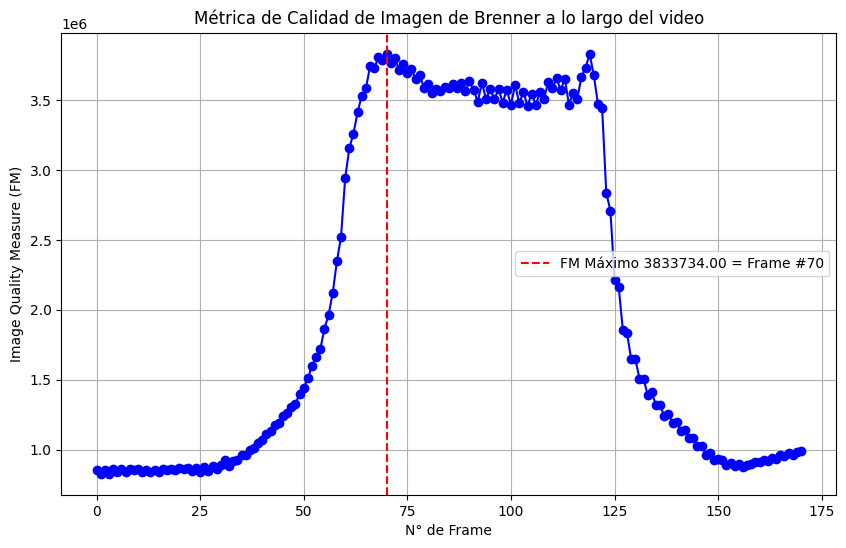

In [29]:
plt.figure(figsize=(10, 6))
plt.plot(FM, marker='o', color='b')
plt.axvline(x=max_frame_index, color='r', linestyle='--', label=f'FM Máximo {max_FM:.2f} = Frame #{max_frame_index}')
plt.title('Métrica de Calidad de Imagen de Brenner a lo largo del video')
plt.xlabel('N° de Frame')
plt.ylabel('Image Quality Measure (FM)')
plt.grid(True)
plt.legend()
plt.show()

Mostramos frame de máximo enfoque

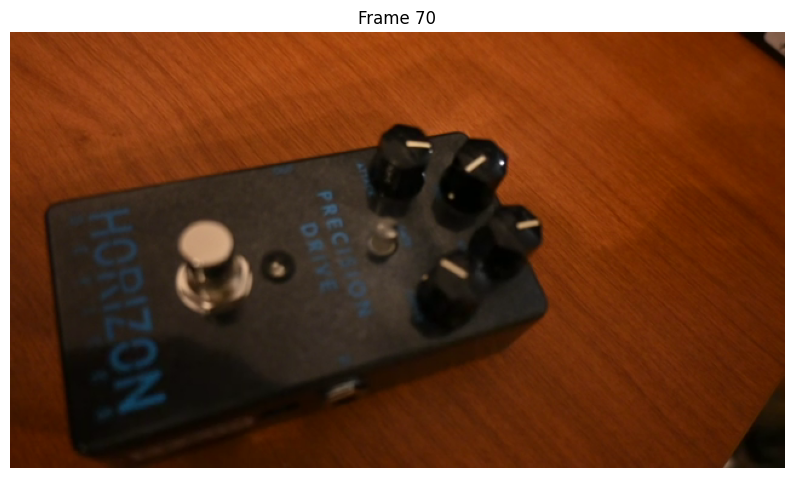

In [30]:
captura_video = cv.VideoCapture(video_path)

# Define el número de frame a leer
n_frame = max_frame_index

# Verifica si el video se abrió correctamente
if not captura_video.isOpened():
    print("Error al abrir el archivo de video")
else:
    # Llevar el video al frame deseado y leerlo
    captura_video.set(cv.CAP_PROP_POS_FRAMES, n_frame)
    ret, frame = captura_video.read()
    if ret:
        mostrar_imagen(frame, titulo=f'Frame {n_frame}')

# Libera el objeto de captura de video
captura_video.release()
cv.destroyAllWindows()

Si bien la forma de la curva tiene forma de campara como la métrica del punto 1, el frame de máximo enfoque es uno que en el punto 1 tenía una métrica más baja, y la imagen a simple vista parece menos enfocada, por lo que no sería una métrica óptima.

### 2.2 Medición sobre una ROI ubicada en el centro del frame. 

In [31]:
def medir_enfoque_roi(video_path, measure_function, roi_area_percent=5):
    captura_video = cv.VideoCapture(video_path)
    if not captura_video.isOpened():
        print("Error al abrir el archivo de video")
        return None, None, None, None, None
    
    frame_width = int(captura_video.get(cv.CAP_PROP_FRAME_WIDTH))
    frame_height = int(captura_video.get(cv.CAP_PROP_FRAME_HEIGHT))
    
    roi_side = int(np.sqrt((roi_area_percent / 100) * frame_width * frame_height))
    roi_width = roi_side
    roi_height = roi_side
    
    x_start = (frame_width - roi_width) // 2
    y_start = (frame_height - roi_height) // 2
    
    num_frames = int(captura_video.get(cv.CAP_PROP_FRAME_COUNT))
    FM = []
    
    for _ in range(num_frames):
        ret, frame = captura_video.read()
        if not ret:
            break
        roi_frame = frame[y_start:y_start + roi_height, x_start:x_start + roi_width]
        FM.append(measure_function(roi_frame))
    
    captura_video.release()
    cv.destroyAllWindows()
    
    FM = np.array(FM)
    max_FM = np.max(FM)
    max_frame_index = np.argmax(FM)
    roi_area = (roi_width * roi_height) / (frame_width * frame_height) * 100
    roi_size = (roi_width, roi_height)
    
    return FM, max_FM, max_frame_index, roi_area, roi_size

C:\Users\alope\AppData\Local\Temp\ipykernel_30176\1994711889.py:25: RuntimeWarning: overflow encountered in scalar subtract
  diff = image[x, y] - image[x + 2, y]


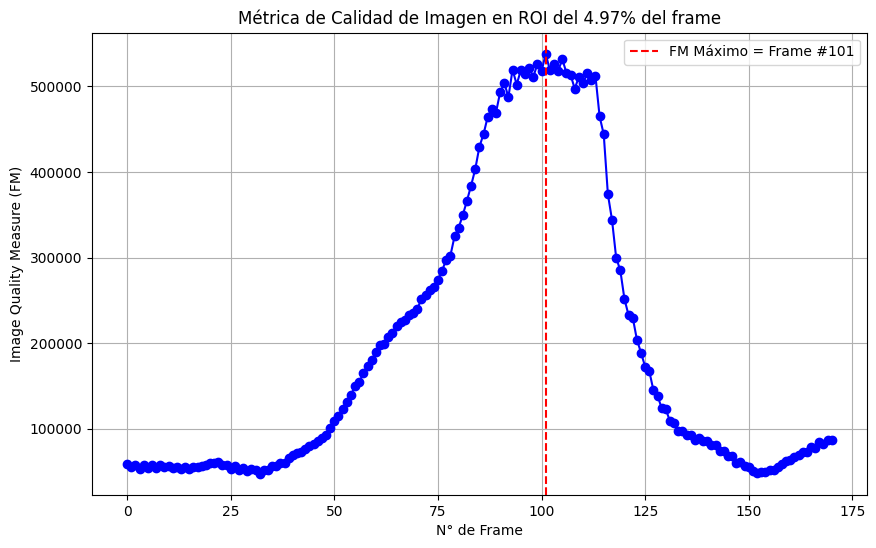

In [32]:
FM, max_FM, max_frame_index, roi_area, roi_size = medir_enfoque_roi(video_path, ImageQualityMeasureBrenner, 5)

plt.figure(figsize=(10,6))
plt.plot(FM, marker='o', color='b')
plt.axvline(x=max_frame_index, color='r', linestyle='--', label=f'FM Máximo = Frame #{max_frame_index}')
plt.title(f'Métrica de Calidad de Imagen en ROI del {roi_area:.2f}% del frame')
plt.xlabel('N° de Frame')
plt.ylabel('Image Quality Measure (FM)')
plt.grid(True)
plt.legend()
plt.show()

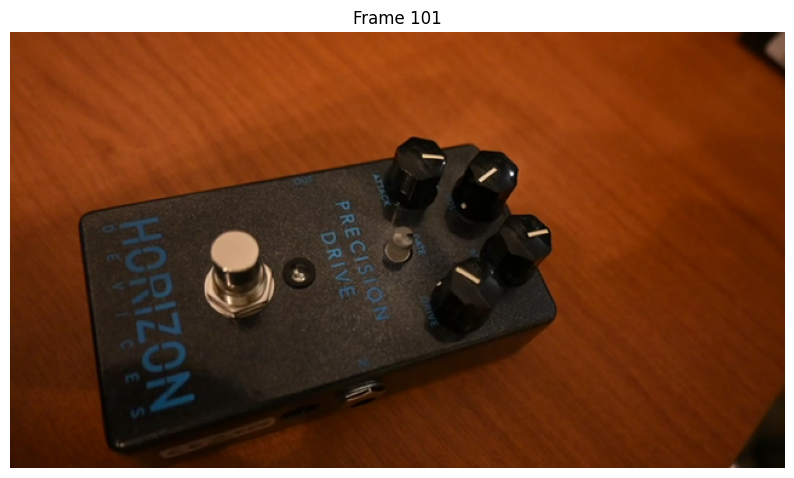

In [33]:
captura_video = cv.VideoCapture(video_path)

# Define el número de frame a leer
n_frame = max_frame_index

# Verifica si el video se abrió correctamente
if not captura_video.isOpened():
    print("Error al abrir el archivo de video")
else:
    # Llevar el video al frame deseado y leerlo
    captura_video.set(cv.CAP_PROP_POS_FRAMES, n_frame)
    ret, frame = captura_video.read()
    if ret:
        mostrar_imagen(frame, titulo=f'Frame {n_frame}')

# Libera el objeto de captura de video
captura_video.release()
cv.destroyAllWindows()

Se observa que ahora la métrica arroja un mejor resultado al tomar el área centrada, ya que el frame elegido tiene mejor enfoque

### Aplicar Unsharp masking
Aplicamos Unsharp Masking con k=1 de acuerdo a la métrica del punto 1 para aquellas imágenes que tienen una medida de calidad entre 0.7 y 0.8

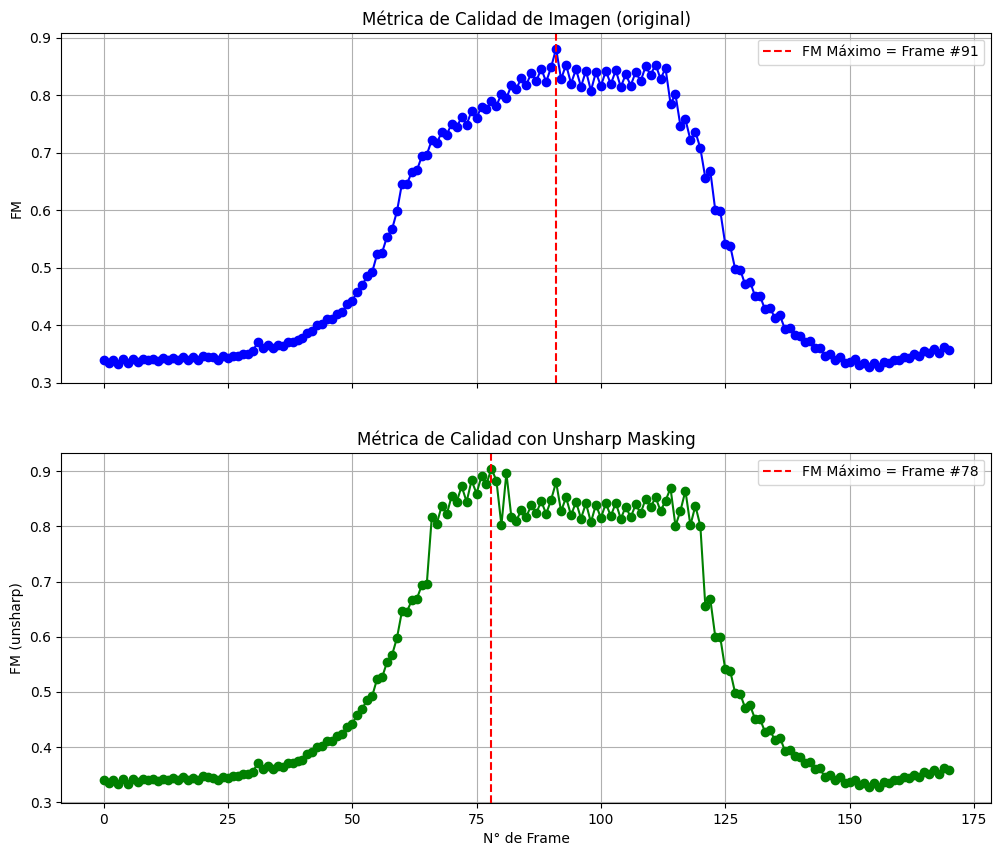

In [35]:
k = 1
# Abre el video
video_path = 'videos/focus_video.mov'
captura_video = cv.VideoCapture(video_path)

if not captura_video.isOpened():
    print("Error al abrir el archivo de video")
else:
    num_frames = int(captura_video.get(cv.CAP_PROP_FRAME_COUNT))
    FM = []
    FM_unsharp_masking = []
    for i in range(num_frames):
        ret, frame = captura_video.read()
        if ret:
            image_quality = ImageQualityMeasure(frame)
            FM.append(image_quality)
            # Si la medida se encuentra entre 0.7 y 0.8 aplicar unsharp masking, sino guardar valor original
            if image_quality >= 0.7 and image_quality <= 0.8:
                gauss = cv.GaussianBlur(frame, (7,7), 0.5)
                img_sharp2 = cv.addWeighted(frame, k+1, gauss, -k, 0)
                FM_unsharp_masking.append(ImageQualityMeasure(img_sharp2))
            else:
                FM_unsharp_masking.append(image_quality)
        else:
            break

# Libera el objeto de captura de video
captura_video.release()
cv.destroyAllWindows()

# Calcula el frame con máximo valor de FM
max_FM = np.max(FM)
max_frame_index = np.argmax(FM)
max_frame_index_unsharp = np.argmax(FM_unsharp_masking)

# Muestra los resultados
fig, axs = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Primer subplot: métrica original
axs[0].plot(FM, marker='o', color='b')
axs[0].axvline(x=max_frame_index, color='r', linestyle='--', label=f'FM Máximo = Frame #{max_frame_index}')
axs[0].set_title('Métrica de Calidad de Imagen (original)')
axs[0].set_ylabel('FM')
axs[0].grid(True)
axs[0].legend()

# Segundo subplot: métrica con unsharp masking
axs[1].plot(FM_unsharp_masking, marker='o', color='g')
axs[1].axvline(x=max_frame_index_unsharp, color='r', linestyle='--', label=f'FM Máximo = Frame #{max_frame_index_unsharp}')
axs[1].set_title('Métrica de Calidad con Unsharp Masking')
axs[1].set_xlabel('N° de Frame')
axs[1].set_ylabel('FM (unsharp)')
axs[1].grid(True)
axs[1].legend()

Se observa que aplicando Unsharp Masking, aún usando k=1, los valores que eran de menor enfoque dentro de la banda de 0.7 a 0.8 ahora igualan e incluso superan a los que antes tenían mayor valor en la métrica. Graficamos el frame de máximo valor, que es uno de los que tiene aplicado Unsharp Masking:

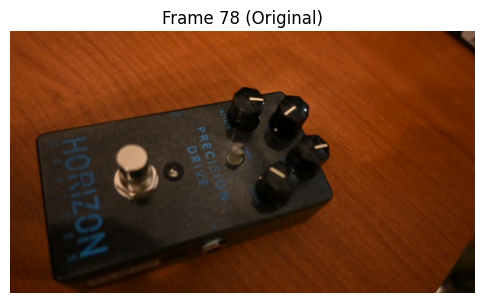

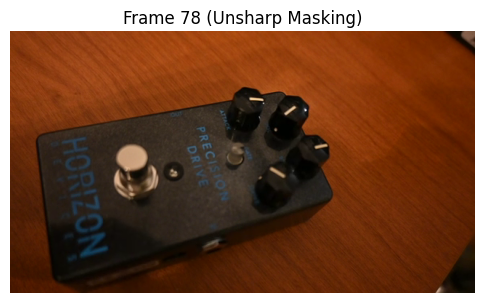

In [37]:
# Carga ese frame
video_path = 'videos/focus_video.mov'
captura_video = cv.VideoCapture(video_path)

if not captura_video.isOpened():
    print("Error al abrir el archivo de video")
else:
    captura_video.set(cv.CAP_PROP_POS_FRAMES, max_frame_index_unsharp)
    ret, frame = captura_video.read()
    if ret:
        # Muestra imagen original
        mostrar_imagen(frame, titulo=f'Frame {max_frame_index_unsharp} (Original)')

        # Aplica unsharp masking y muestra imagen resultante
        k = 1
        gauss = cv.GaussianBlur(frame, (7,7), 0.5)
        img_sharp2 = cv.addWeighted(frame, k+1, gauss, -k, 0)
        mostrar_imagen(img_sharp2, titulo=f'Frame {max_frame_index_unsharp} (Unsharp Masking)')

captura_video.release()
cv.destroyAllWindows()


Se observa que efectivamente Unsharp Masking mejoró el enfoque de la imagen, por lo que ahora resulta la imagen de mayor enfoque. Se concluye que la técnica es efectiva, teniendo en cuenta la restricción que adoptamos de sólo aplicarlo a imágenes que estén ligeramente desenfocadas, y no a aquellas que lo están totalmente.